# 3. Monthly prediction with U-net

based on current month's predictors (no lag)

In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd

from models.grid_to_grid import unet2d
from utils.helpers import *
import tensorflow as tf
from tensorflow.keras import backend as K
import models.masked_unet_loss as mul

from utils.helpers import stack_covariates

from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint

2025-11-27 09:42:21.515625: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 09:42:21.566750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
root_path = './data/Bangladesh'
inputs_path = f'{root_path}/inputs'
fill_value = -1
lag = 5

In [3]:
cv_setup = np.load(f'{root_path}/cv_setup.npy', allow_pickle=True).item()
train_ids = cv_setup['train_ids']
holdout_ids = cv_setup['holdout_ids']
tr_idxs = cv_setup['tr_idxs']
test_idxs = cv_setup['test_idxs']
seed = cv_setup['seed']

tf.random.set_seed(seed)

In [4]:
bgd_shp = gpd.read_file(f'{root_path}/BGD_shp/vb025yv7599.shp')
info_file = pd.read_csv(f'{root_path}/target/well_info.csv')
full_ndvi_da = xr.open_mfdataset(f'{root_path}/inputs/NDVI_M_2002_2017_BGD_025.nc4')['NDVI'][(lag-1):]
full_ndvi_da['time'] = [x + pd.DateOffset(days=14) for x in full_ndvi_da['time'].values ]

In [5]:
filled_ts = pd.read_csv(f"{root_path}/target/filtered_filled_missForest_gws_ts_data_1961_2019.csv", parse_dates=['Date'], index_col='Date')
filled_ts = filled_ts['2002-04-01':'2017-05-31'].dropna(axis=1, how='any')
filled_ts_gwsa = filled_ts - filled_ts['2004-01-01':'2009-12-31'].mean()

df_train = filled_ts_gwsa[train_ids].iloc[(lag-1):]

In [6]:
target_da = xr.full_like(full_ndvi_da, fill_value=None).rename('gwsa')
info_file_filtered = info_file[info_file['OldID'].isin(train_ids)]
start_date = df_train.index[0].strftime('%Y-%m-%d')

info_file_filtered["grid_cell"] = info_file_filtered.apply(
    lambda row: assign_to_grid((row["Latitude"], row["Longitude"]), 
                               full_ndvi_da.lat.values, 
                               full_ndvi_da.lon.values), axis=1
)

# Group the points by their grid cell
grouped_points = info_file_filtered.groupby("grid_cell")

for grid_cell, group in grouped_points:
    series_list = [filled_ts_gwsa.loc[:, wid] for wid in group.SegmentID]
    cc_df = pd.concat(series_list, axis=1)

    mean_values = cc_df.mean(axis=1)

    time_indexer = xr.DataArray(
        [months_between_dates(start_date, t.strftime("%Y-%m-%d"))
         for t in mean_values.index],
        dims=["time_src"],
    )

    tmp = xr.DataArray(mean_values.values, dims=["time_src"])

    arr1d = np.full((target_da.sizes["time"],), np.nan, dtype=target_da.dtype)
    arr1d[time_indexer.values] = tmp.values  # vectorized scatter

    target_da[:, grid_cell[0], grid_cell[1]] = xr.DataArray(
        arr1d, dims=["time"], coords={"time": target_da.time}
    )

/tmp/ipykernel_39996/2931934483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_file_filtered["grid_cell"] = info_file_filtered.apply(


In [7]:
# predictors
full_dem_da = xr.open_dataset(f'{inputs_path}/DEM_BGD_025.nc4')['dem'][0]
full_ndvi_da = xr.open_dataset(f'{inputs_path}/NDVI_M_2002_2017_BGD_025.nc4')['NDVI'][(lag-1):]
full_twsa_da = xr.open_dataset(f'{inputs_path}/TWSA_M_2002_2017_BGD_025.nc4')['twsa'][(lag-1):]
full_era_ds = xr.open_dataset(f'{inputs_path}/PR_AET_M_2002_2017_BGD_025.nc4')

full_aet_da = full_era_ds['aet'][(lag-1):]
full_precip_da = full_era_ds['pr'][(lag-1):]

cov_das = [full_dem_da, full_ndvi_da, full_twsa_da, full_aet_da, full_precip_da]
times = (filled_ts[(lag-1):].index - pd.DateOffset(days=14)).values
cov_stack = stack_covariates(cov_das, times).to_numpy()

In [8]:
input_shape = (24,24,5)

In [9]:
unet2d(input_shape).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 24, 5)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 24, 24, 16)           736       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 24, 24, 16)           2320      ['conv2d[0][0]']              
                                                                                                  
 drop_c1 (Dropout)           (None, 24, 24, 16)           0         ['conv2d_1[0][0]']            
                                                                                              

In [10]:
for k, (tr_idx, val_test_idx) in enumerate(zip(tr_idxs, test_idxs)):
    unet_model = unet2d(input_shape)

    val_idx, tes_idx = val_test_idx[:int(len(val_test_idx)/2)], val_test_idx[int(len(val_test_idx)/2):]

    y_fold_tr = target_da[tr_idx]
    y_fold_val = target_da[val_idx]

    y_min, y_max = y_fold_tr.min().values.item(), y_fold_tr.max().values.item()
    y_fold_tr_scaled = (y_fold_tr - y_min)/(y_max - y_min)
    y_fold_val_scaled = (y_fold_val - y_min)/(y_max - y_min)
    Y_tr = y_fold_tr_scaled.fillna(fill_value).to_numpy()[..., np.newaxis]
    Y_val = y_fold_val_scaled.fillna(fill_value).to_numpy()[..., np.newaxis]
    
    input_train = cov_stack[tr_idx]
    input_val = cov_stack[val_idx]
    input_test = cov_stack[tes_idx]

    input_train[input_train == -1] = np.nan
    input_val[input_val == -1] = np.nan
    input_test[input_test == -1] = np.nan

    x_min, x_max = np.nanmin(input_train, axis=(0,1,2)), np.nanmax(input_train, axis=(0,1,2))
    X_tr = (input_train - x_min) / (x_max - x_min)
    X_val = (input_val - x_min) / (x_max - x_min)
    X_test = (input_test - x_min) / (x_max - x_min)
    X_tr[np.isnan(X_tr)] = -1
    X_val[np.isnan(X_val)] = -1
    X_test[np.isnan(X_test)] = -1

    mask_train = np.where(X_tr == -1, 0, 1)
    mask_val = np.where(X_val == -1, 0, 1)
    mask_test = np.where(X_test == -1, 0, 1)

    masked_loss = mul.make_masked_mse_loss(mul._resize_bool_mask(Y_tr[0] != -1))
    unet_model.compile(optimizer = 'adam', loss = masked_loss, metrics = [ 'mse' ])

    unet_model.fit(X_tr,
               Y_tr,
               batch_size=10,
               epochs=60,
               validation_data=[X_val, Y_val],
               #callbacks=[
                  # ModelCheckpoint(filepath='unet.weights.best.hdf5',
                  #                 save_best_only=True,
                  #                 verbose=1),
               #    PlotLossesCallback()],
               verbose=0)
    
    full_pred_target = unet_model.predict(
        np.concatenate((X_tr, X_val, X_test), axis=0),
        batch_size=5)

    dates = target_da.time[:(tes_idx[-1]+1)]
    full_pred_target_da = xr.DataArray(np.squeeze(full_pred_target), coords={'time': dates,'lat': target_da.lat, 'lon': target_da.lon}, dims=['time', 'lat', 'lon'])
    
    # clip to Bangladesh
    full_pred_target_da = full_pred_target_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    full_pred_target_da = full_pred_target_da.rio.write_crs("epsg:4326", inplace=True)
    full_pred_target_da = full_pred_target_da.rio.clip(bgd_shp.geometry.values, bgd_shp.crs, all_touched=True)
    
    denorm_pred_da = full_pred_target_da * (y_max - y_min) + y_min

    (
        denorm_pred_da.to_dataset(name=f'gwsa_pred')
            .to_netcdf(f'{root_path}/outputs/2D_Unet/2d_unet_filled_gwsa_fold_{k}.nc4')
    )

36/36 [==============================] - 0s 3ms/step


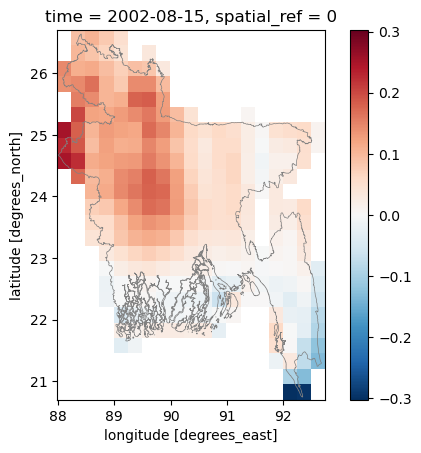

In [11]:
bgd_shp.boundary.plot(color='gray', linewidth=0.5)
denorm_pred_da[0].plot()